# Update Recent Stock Prices and Visualize
This notebook updates the `assets.db` with the latest stock prices from Alpaca, queries stock prices for a specific ticker over a date range, and plots the OHLC (Open, High, Low, Close) prices with user-selectable smoothing methods (exponential smoothing, LOWESS, or moving average).

In [1]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statsmodels.api as sm
import sys
from pathlib import Path
import os

# Define BASE_DIR and adjust sys.path before importing
BASE_DIR = Path(os.getcwd()).parent  # Points to stat_656_autotrader/ from Notebooks/
sys.path.append(str(BASE_DIR))
print(f"Project root added to sys.path: {BASE_DIR}")

# Import paths from the config module
from src.config import BASE_DIR, DB_DIR
from credentials import ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPAKA_ENDPOINT_URL

from src.utils.alpaca_utils import connect_to_alpaca, fetch_alpaca_stock_tickers
from src.utils.db_utils import get_db_connection, fetch_active_tickers, last_data_date, last_fetch_date, fetch_database_stock_tickers, fetch_price_range
from src.visualizations.stock_price_trends import plot_stock_trends_with_intervals
from src.statistics.smoothers import smooth_lowess

Project root added to sys.path: d:\dev\stat_656_autotrader


# Connect and Fetch Tickers

In [2]:
# Obtainthe last datetime date.
last_data_date()

datetime.date(2025, 4, 15)

In [3]:


alpaca_client = connect_to_alpaca(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPAKA_ENDPOINT_URL)
alpaca_tickers = fetch_alpaca_stock_tickers(alpaca_client, exchanges=['NASDAQ', 'NYSE', 'AMEX'])
db_tickers = fetch_database_stock_tickers()


In [4]:
def compare_ticker_lists(db_tickers, alpaca_tickers):
    """Compare two lists of stock tickers and identify dropped and added tickers.

    Parameters
    ----------
    db_tickers : list
        List of ticker symbols from the database (e.g., from fetch_database_stock_tickers).
    alpaca_tickers : list
        List of ticker symbols from Alpaca API (e.g., from fetch_alpaca_stock_tickers).

    Returns
    -------
    tuple
        A tuple containing two lists:
        - dropped_tickers: List of tickers present in db_tickers but not in alpaca_tickers.
        - added_tickers: List of tickers present in alpaca_tickers but not in db_tickers.

    Examples
    --------
    >>> db_list = ['AAPL', 'GOOGL', 'FB']
    >>> alpaca_list = ['AAPL', 'TSLA', 'GOOGL']
    >>> dropped, added = compare_ticker_lists(db_list, alpaca_list)
    >>> print("Dropped:", dropped)
    Dropped: ['FB']
    >>> print("Added:", added)
    Added: ['TSLA']
    """
    # Convert lists to sets for efficient comparison
    db_set = set(db_tickers)
    alpaca_set = set(alpaca_tickers)
    
    # Find tickers in db_tickers but not in alpaca_tickers (dropped)
    dropped_tickers = list(db_set - alpaca_set)
    
    # Find tickers in alpaca_tickers but not in db_tickers (added)
    added_tickers = list(alpaca_set - db_set)
    
    return dropped_tickers, added_tickers

In [5]:
compare_ticker_lists(db_tickers, alpaca_tickers)

(['FFNW',
  'CSA',
  'SYRA',
  'ENFN',
  'EQC',
  'MKFG',
  'OCEA',
  'ONVO',
  'ENZ',
  'MDCP',
  'CMRX',
  'STKH',
  'CSLR',
  'CTHR',
  'XFOR',
  'NAAS',
  'DEA',
  'CSLRW',
  'CSF',
  'AWH',
  'DTC',
  'STSS',
  'SCPX',
  'AIEV',
  'PDCO',
  'ML',
  'FNA',
  'OCEAW'],
 ['FERA',
  'DVS',
  'CHA',
  'PHOE',
  'IPCXU',
  'AVGB',
  'MBBC',
  'BCTXZ',
  'VIVS',
  'RVNL',
  'LCDL',
  'XOMZ',
  'PLTG',
  'TVACU',
  'NHICW',
  'RAC',
  'BOEU',
  'TMDE',
  'APPX',
  'PFAI',
  'GENVR',
  'CIGL',
  'LOKVW',
  'BOED',
  'NHIC',
  'XOMX',
  'EDHL',
  'SPWRW',
  'SSII',
  'SPWR',
  'LOKV',
  'NPACU',
  'CHACU',
  'FERAR'])

In [6]:
def fetch_database_stock_tickers():
    conn = get_db_connection('assets.db', print_statements=False)
    query = """
    SELECT symbol FROM asset_metadata
    """
    past_ticker_list = pd.read_sql(query, conn)['symbol'].to_list()
    conn.close()
    return past_ticker_list 

In [7]:
# Cell 2: Connect and Fetch Tickers
conn = get_db_connection('assets.db')
print("Connected to assets.db")

active_tickers = fetch_active_tickers()
print(f"Found {len(active_tickers)} active tickers: {list(active_tickers.keys())[:5]}...")


Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Connected to assets.db
Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Found 7458 active tickers: ['PAMT', 'ADNWW', 'ADN', 'AMTX', 'OXSQG']...


In [8]:
sample_ticker = 'AAPL'
days_back = 120

price_data = fetch_price_range(sample_ticker, days_back, conn=conn)
price_data.head()

Querying AAPL prices for last 120 trading days from 2024-10-22 to 2025-04-15
Fetched 120 price records for AAPL


,date,open,high,low,close
0,2024-10-22,233.86,236.180,232.670,235.890
1,2024-10-23,234.10,235.130,227.770,230.675
2,2024-10-24,229.97,230.815,228.420,230.600
3,2024-10-25,229.74,233.120,229.600,231.220
4,2024-10-28,233.32,234.710,232.565,233.510


Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Querying MSFT prices for last 150 trading days from 2024-09-10 to 2025-04-15
Fetched 150 price records for MSFT


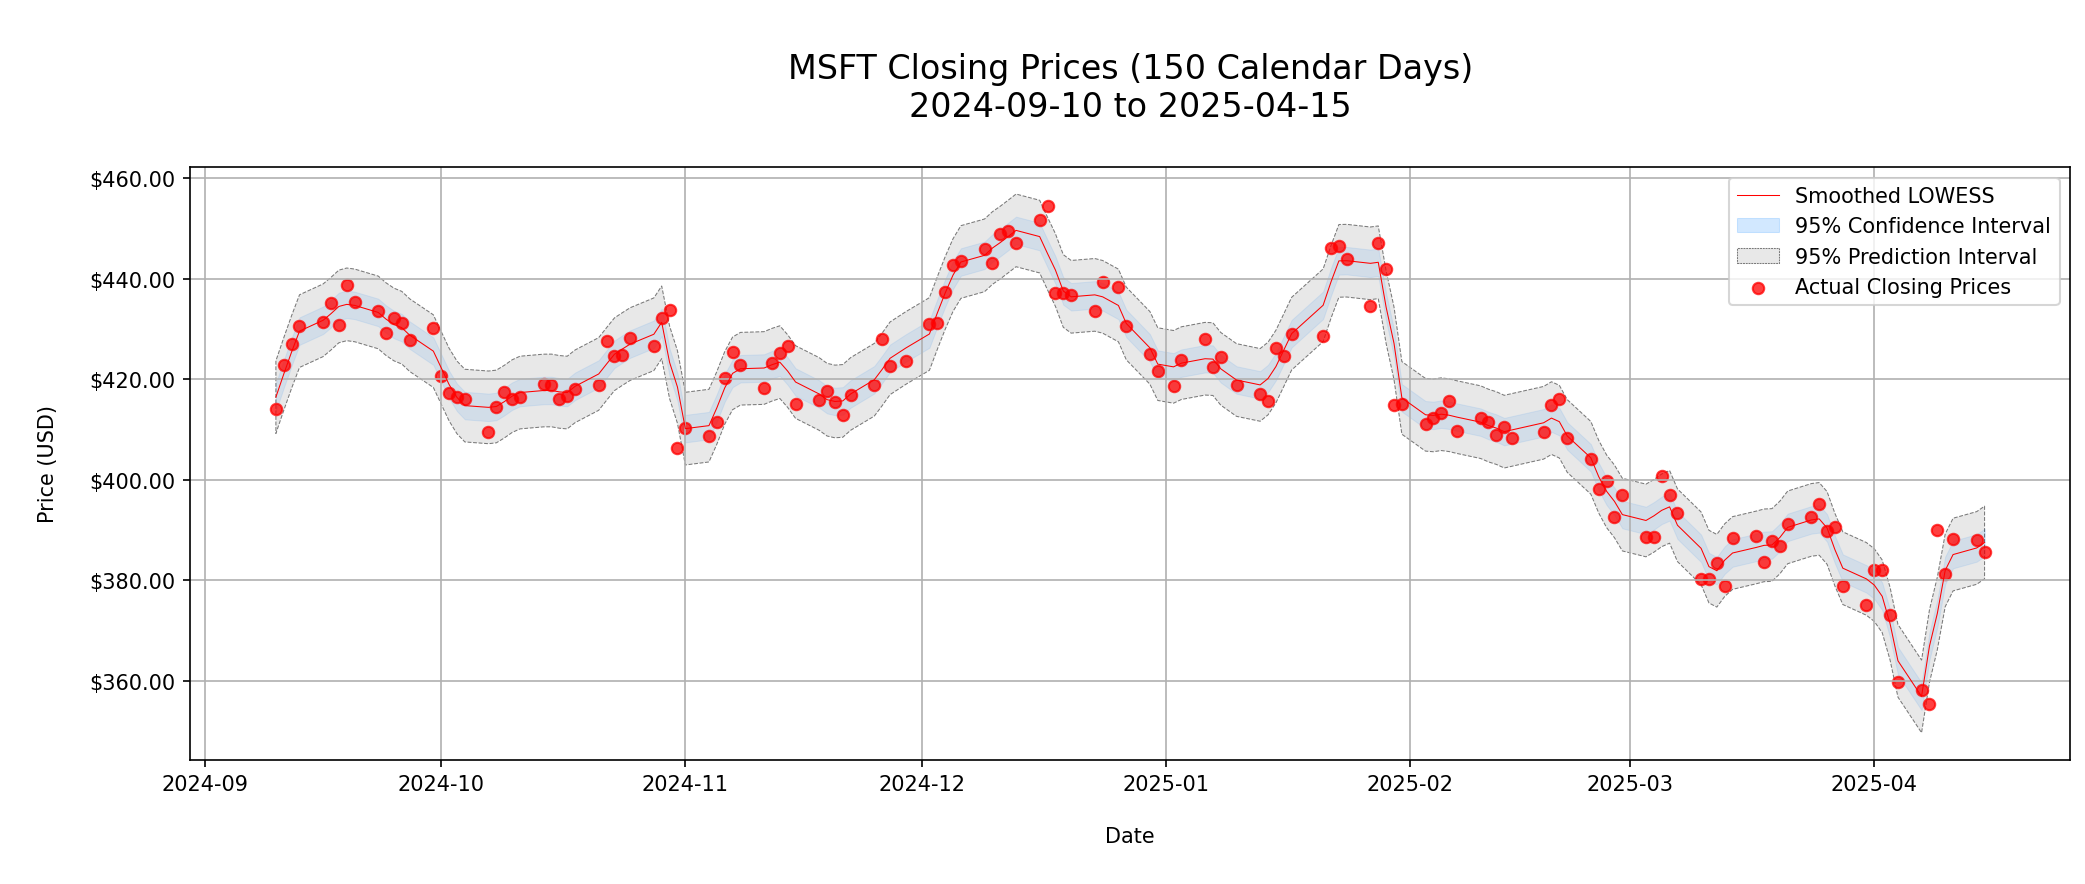

In [13]:
plot_stock_trends_with_intervals(
    symbol = 'MSFT',
    days_back=150,
    smoothing_window=7,
    smoother="lowess",
    price_type="close",
    show_actual_line=False,
    calendar_days=True,
    ci=95
    )


In [10]:
price_data

,date,open,high,low,close
0,2024-10-22,233.860,236.180,232.670,235.890
1,2024-10-23,234.100,235.130,227.770,230.675
2,2024-10-24,229.970,230.815,228.420,230.600
3,2024-10-25,229.740,233.120,229.600,231.220
4,2024-10-28,233.320,234.710,232.565,233.510
...,...,...,...,...,...
115,2025-04-09,172.180,200.570,171.930,198.460
116,2025-04-10,189.065,194.750,183.060,190.630
117,2025-04-11,186.210,199.490,186.210,198.150
118,2025-04-14,211.440,212.870,201.215,202.610


In [11]:
STOP

NameError: name 'STOP' is not defined

# Update Recent Stock Prices

In [ ]:
# Initialize Alpaca client
alpaca = get_alpaca_client()

# Update stock prices for active tickers (e.g., last 5 days)
start_date = datetime.now() - timedelta(days=5)
end_date = datetime.now()

# Pass conn to update_stock_prices (assuming it’s updated to accept conn elsewhere)
updated_tickers = update_stock_prices(alpaca, conn, list(active_tickers.keys()), start_date, end_date)
print(f"Updated prices for {len(updated_tickers)} tickers")